# Gene Set Enrichment Analysis (GSEA)
# Phase 2 vs. Phase 2

uses an entire ranked list (by log2FoldChange) of genes to see if pathway genes cluster at the top or bottom

#### Are *pathways* generally over- or under-expressed in a given treatment?

using [clusterProfiler](https://github.com/YuLab-SMU/clusterProfiler) R package


## 0. load libraries

In [3]:
library(tidyverse)
library(clusterProfiler) # for GSEA()
library(enrichplot) # for enrichment visuals
library(GO.db) # for gene ontology database
library(UpSetR) # for Cvirginica annotations
library(patchwork) # for arranging multiple plots

## 1. read in CSVs

read in GO annotation data

In [4]:
# col1 = gene ID
# col2 = GO ID 
gene2go <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
head(gene2go)

,gene,Gene.Ontology.IDs
,<chr>,<chr>
1,LOC111126949,GO:0005042; GO:0005737; GO:0008233; GO:0016020; GO:0043123; GO:0046330
2,LOC111112434,GO:0000981; GO:0003700; GO:0005634; GO:0016607; GO:0043565; GO:0045944
3,LOC111120752,GO:0004750; GO:0005829; GO:0005975; GO:0006098; GO:0009052; GO:0042802; GO:0042803; GO:0046872; GO:0070062
4,LOC111105685,GO:0003682; GO:0004518; GO:0005634; GO:0035098; GO:0035102; GO:0040029; GO:0046872
5,LOC111113860,GO:0004062; GO:0005737; GO:0006068; GO:0006805; GO:0008146; GO:0009812; GO:0030855; GO:0042403; GO:0050427; GO:0051923
6,LOC111109550,GO:0004062; GO:0005737; GO:0005764; GO:0008146; GO:0051923


re-format for correct input for `GSEA()` - two columns, one for GO term and one for gene ID

In [5]:
term2gene <- gene2go %>%
  mutate(GO_terms = strsplit(Gene.Ontology.IDs, ",\\s*|;\\s*|`")) %>%  # Split by comma, semicolon, or backtick
  unnest(GO_terms) %>%
  filter(grepl("^GO:", GO_terms)) %>%  # Keep only valid GO terms
  dplyr::select(term = GO_terms, gene = gene)

class(term2gene)
str(term2gene)
head(term2gene)

[1] "tbl_df"     "tbl"        "data.frame"

tibble [223,103 × 2] (S3: tbl_df/tbl/data.frame)
 $ term: chr [1:223103] "GO:0005042" "GO:0005737" "GO:0008233" "GO:0016020" ...
 $ gene: chr [1:223103] "LOC111126949" "LOC111126949" "LOC111126949" "LOC111126949" ...


term,gene
<chr>,<chr>
GO:0005042,LOC111126949
GO:0005737,LOC111126949
GO:0008233,LOC111126949
GO:0016020,LOC111126949
GO:0043123,LOC111126949
GO:0046330,LOC111126949


get term names for GO IDs

In [6]:
# Extract GO term descriptions
go_terms <- unique(term2gene$term)

# Get descriptions from GO.db
term2name <- data.frame(
  term = go_terms,
  name = sapply(go_terms, function(x) {
    tryCatch({
      Term(GOTERM[[x]])
    }, error = function(e) {
      NA_character_
    })
  })
)

# Remove NAs
term2name <- term2name[!is.na(term2name$name), ]

# View
head(term2name)    

,term,name
,<chr>,<chr>
GO:0005042,GO:0005042,netrin receptor activity
GO:0005737,GO:0005737,cytoplasm
GO:0008233,GO:0008233,peptidase activity
GO:0016020,GO:0016020,membrane
GO:0043123,GO:0043123,positive regulation of canonical NF-kappaB signal transduction
GO:0046330,GO:0046330,positive regulation of JNK cascade


read in *all* genes from DESeq output (not just DEGs)

In [7]:
# get list of files
files <- list.files(
    path = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes',
    pattern = '\\.csv$',
    full.names = TRUE
    )

head(files)

[1] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bb_cc.csv"
[2] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_bb.csv"
[3] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_cc.csv"
[4] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_hc.csv"
[5] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_wc.csv"
[6] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bh_ch.csv"

In [8]:
names(files) <- tools::file_path_sans_ext(basename(files))
df_list <- lapply(files, read.csv)
names(df_list)
length(df_list)

[1] "bb_cc" "bc_bb" "bc_cc" "bc_hc" "bc_wc" "bh_ch" "bh_hh" "bw_cw" "bw_ww"
[10] "cb_bb" "cb_bc" "cb_cc" "cb_ch" "cb_cw" "ch_cc" "ch_hc" "cw_cc" "cw_ch"
[19] "cw_wc" "hb_bb" "hb_bh" "hb_cb" "hc_cc" "hc_hh" "hh_cc" "hh_ch" "wb_bb"
[28] "wb_bw" "wb_cb" "wc_cc" "wc_hc" "wc_ww" "wh_hw" "ww_cc" "ww_cw"

[1] 35

## 2. Formatting CSVs
input to `gsea()` is an order ranked geneList - I'm going to rank by log2FoldChange

In [12]:
# create numeric vector, ordered by LFC
all_df <- lapply(df_list, function(df) {
    geneList <- df$log2FoldChange 
    # Set gene IDs as names
    names(geneList) <- df$Gene
    
    # Sort in decreasing order
    geneList <- sort(geneList, decreasing = TRUE)

    return(geneList)
    })

# check things look okay 
head(all_df$bb_cc)

LOC111132404 LOC111103543 LOC111114729 LOC111112633 LOC111123832 LOC111113513 
    28.24743     27.35694     24.07887     23.70125     23.56809     23.41851

## 3. Run GSEA

Output notes [from here](https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideTEXT.htm):
- setSize
- enrichmentScore - degree to which the gene set is overrepresented at the top or bottom of a ranked list of genes (pos = top of list, neg = bottom of list)
- NES - normalized enrichment score; should be used to compare analysis results across gene sets
- qvalue - also FDR (false discovery rate)
- rank
- leading_edge - core group of genes that accounts for the gene set's enrichment signal
- core_enrichment - subset of genes that contributes most to the enrichment result

geneRatio - how much of a pathway (gene set) is represented in ranked genes that contribute to the enrichment signal

### 1. effect of single exposure after period of recovery
- CC vs. WC
- CC vs. HC
- CC vs. BC

In [14]:
# CC vs. WC
gsea_res_cc.wc <- GSEA(
    geneList = all_df$wc_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_cc.wc)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.54% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
GO:0010591,GO:0010591,regulation of lamellipodium assembly,13,0.9998086,1.481078,7.368820e-07,0.002695514,0.002695514,6,"tags=8%, list=0%, signal=8%",LOC111109183
GO:0032956,GO:0032956,regulation of actin cytoskeleton organization,56,0.9995487,1.371644,7.345432e-06,0.013434794,0.013434794,6,"tags=2%, list=0%, signal=2%",LOC111109183
GO:0031252,GO:0031252,cell leading edge,46,0.9995668,1.400511,1.429662e-05,0.017432346,0.017432346,6,"tags=2%, list=0%, signal=2%",LOC111109183


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the enrichplot package.
  Please report the issue at
  <https://github.com/GuangchuangYu/enrichplot/issues>.”


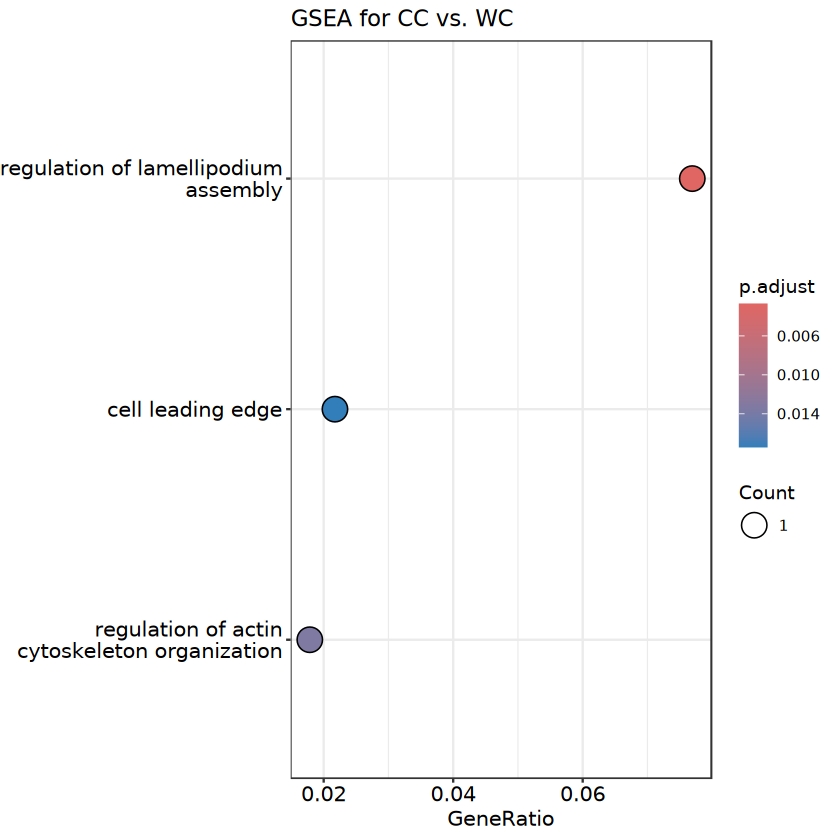

In [17]:
dotplot(gsea_res_cc.wc, showCategory=20) + ggtitle('GSEA for CC vs. WC')

- lamellipodium - primarily found in mobile cells, involved in quick repair of wounds, pulls the cell forward during cell migration
- cell leading edge - area of motile cell closest to direction of movement

so seems we have GO terms enriched for cell movement/motility?

In [15]:
# CC vs. HC
gsea_res_cc.hc <- GSEA(
    geneList = all_df$hc_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_cc.hc)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.57% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0031252,GO:0031252,cell leading edge,46,0.9996732,1.373480,3.546366e-08,6.486303e-05,6.486303e-05,3,"tags=2%, list=0%, signal=2%",LOC111109183
GO:0017124,GO:0017124,SH3 domain binding,69,0.9995460,1.311282,3.398635e-08,6.486303e-05,6.486303e-05,3,"tags=1%, list=0%, signal=1%",LOC111109183
GO:0048813,GO:0048813,dendrite morphogenesis,90,0.9990514,1.309866,1.783488e-06,2.174666e-03,2.174666e-03,3,"tags=1%, list=0%, signal=1%",LOC111109183
GO:0030335,GO:0030335,positive regulation of cell migration,108,0.9987684,1.294721,3.192113e-06,2.919187e-03,2.919187e-03,3,"tags=1%, list=0%, signal=1%",LOC111109183
GO:0051491,GO:0051491,positive regulation of filopodium assembly,37,0.9997224,1.406959,8.097887e-06,5.924414e-03,5.924414e-03,3,"tags=3%, list=0%, signal=3%",LOC111109183
GO:0005813,GO:0005813,centrosome,397,-0.9924947,-1.191863,3.332723e-05,2.031850e-02,2.031850e-02,119,"tags=1%, list=0%, signal=1%",LOC111110522/LOC111101003/LOC111125439
GO:0032956,GO:0032956,regulation of actin cytoskeleton organization,56,0.9991459,1.357386,6.237864e-05,3.259729e-02,3.259729e-02,3,"tags=2%, list=0%, signal=2%",LOC111109183
GO:0000781,GO:0000781,"chromosome, telomeric region",96,-0.9985560,-1.213395,7.912100e-05,3.617808e-02,3.617808e-02,21,"tags=2%, list=0%, signal=2%",LOC111107528/LOC111125439
GO:0045886,GO:0045886,negative regulation of synaptic assembly at neuromuscular junction,10,0.9999285,1.507024,1.045416e-04,4.136218e-02,4.136218e-02,3,"tags=10%, list=0%, signal=10%",LOC111109183


kinda same deal as CC vs. WC above - a lot of enriched terms for cell motility (cell leading edge, pos. reg. of cell migration) - also telomeric region and double-strand break repair which could suggest cellular damage

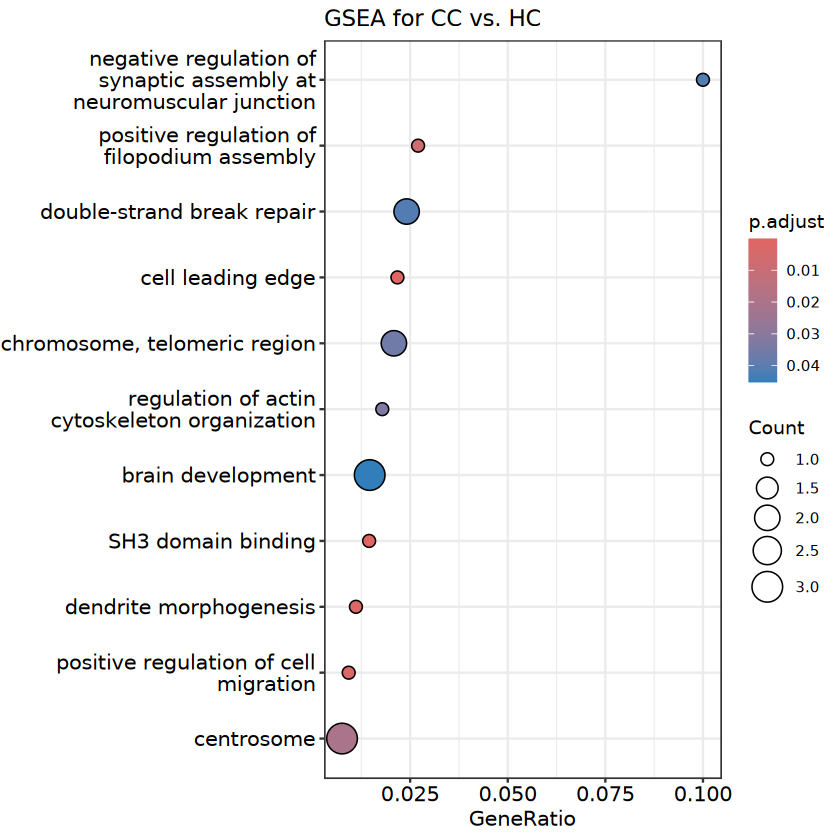

In [18]:
dotplot(gsea_res_cc.hc, showCategory=20) + ggtitle('GSEA for CC vs. HC')

In [16]:
# CC vs. BC
gsea_res_cc.bc <- GSEA(
    geneList = all_df$bc_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_cc.bc)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.55% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
GO:0005815,GO:0005815,microtubule organizing center,96,0.9933065,1.249016,1.405329e-08,5.140695e-05,5.140695e-05,25,"tags=1%, list=0%, signal=1%",LOC111099630
GO:0032956,GO:0032956,regulation of actin cytoskeleton organization,56,0.9954900,1.255539,7.119182e-07,1.302098e-03,1.302098e-03,9,"tags=2%, list=0%, signal=2%",LOC111109183
GO:0043130,GO:0043130,ubiquitin binding,84,0.9900644,1.241672,3.891052e-06,4.744490e-03,4.744490e-03,25,"tags=1%, list=0%, signal=1%",LOC111099630
GO:0003779,GO:0003779,actin binding,178,0.9646868,1.238502,2.359254e-05,2.157538e-02,2.157538e-02,536,"tags=3%, list=1%, signal=3%",LOC111109183/LOC111109917/LOC111125873/LOC111109791/LOC111134386
GO:0090543,GO:0090543,Flemming body,33,0.9962911,1.261154,5.185523e-05,3.793728e-02,3.793728e-02,25,"tags=3%, list=0%, signal=3%",LOC111099630


ubiquitin binding - when ubiquitin is bound, marks the cell for proteolytic degradation

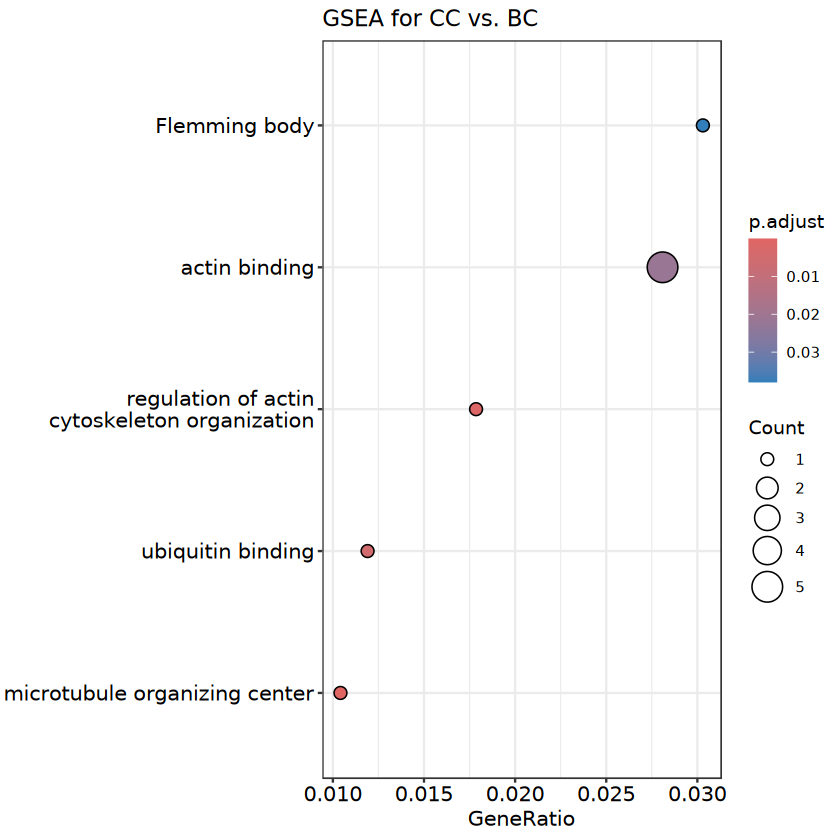

In [43]:
dotplot(gsea_res_cc.bc, showCategory=20) + ggtitle('GSEA for CC vs. BC')

### 2. effect of single late exposure
- CC vs. CW
- CC vs. CH
- CC vs. CB

In [44]:
# CC vs. CW
gsea_res_cc.cw <- GSEA(
    geneList = all_df$cw_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_cc.cw)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.77% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [45]:
# CC vs. CH
gsea_res_cc.ch <- GSEA(
    geneList = all_df$ch_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_cc.ch)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.6% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [46]:
# CC vs. CB
gsea_res_cc.cb <- GSEA(
    geneList = all_df$cb_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_cc.cb)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.75% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

so all of the comparisons in this group didn't have any enriched GO terms, but when the single stress is early, we have a lot more enriched GO terms ...

### 3. Effect of timing of initial stress exposure
- CW vs. WC
- CH vs. HC
- CB vs. BC

In [51]:
names(all_df)

[1] "bb_cc" "bc_bb" "bc_cb" "bc_cc" "bc_hc" "bc_wc" "bh_hh" "bw_ww" "cb_bb"
[10] "cb_bc" "cb_cc" "cb_ch" "cb_cw" "ch_cc" "ch_hc" "cw_cc" "cw_ch" "cw_wc"
[19] "hb_bb" "hb_bh" "hb_cb" "hc_cc" "hc_ch" "hc_hh" "hh_cc" "hh_ch" "wb_bb"
[28] "wb_bw" "wb_cb" "wc_cc" "wc_cw" "wc_hc" "wc_ww" "wh_hw" "ww_cc" "ww_cw"

In [50]:
# CW vs. WC
gsea_res_cw.wc <- GSEA(
    geneList = all_df$cw_wc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_cw.wc)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.62% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [52]:
# CC vs. CH
gsea_res_ch.hc <- GSEA(
    geneList = all_df$ch_hc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_ch.hc)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.41% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0005813,GO:0005813,centrosome,397,0.9950335,1.311284,2.438230e-07,0.0008919046,0.0008919046,92,"tags=1%, list=0%, signal=1%",LOC111125439/LOC111101003
GO:0016125,GO:0016125,sterol metabolic process,16,-0.9994091,-1.431054,2.026210e-05,0.0124859224,0.0124859224,3,"tags=12%, list=0%, signal=13%",LOC111110307/LOC111100601
GO:0008401,GO:0008401,retinoic acid 4-hydroxylase activity,19,-0.9998217,-1.430211,1.418384e-05,0.0124859224,0.0124859224,3,"tags=11%, list=0%, signal=11%",LOC111111884/LOC111100601
GO:0006974,GO:0006974,DNA damage response,276,0.9953027,1.237313,8.144201e-06,0.0124859224,0.0124859224,92,"tags=1%, list=0%, signal=1%",LOC111125439/LOC111101003
GO:0000287,GO:0000287,magnesium ion binding,210,0.9963763,1.219957,1.938170e-05,0.0124859224,0.0124859224,18,"tags=0%, list=0%, signal=0%",LOC111125439
GO:0000781,GO:0000781,"chromosome, telomeric region",96,0.9985554,1.217197,2.047992e-05,0.0124859224,0.0124859224,18,"tags=1%, list=0%, signal=1%",LOC111125439
GO:0042573,GO:0042573,retinoic acid metabolic process,19,-0.9997915,-1.430168,2.422341e-05,0.0126584628,0.0126584628,3,"tags=11%, list=0%, signal=11%",LOC111111884/LOC111100601
GO:0061749,GO:0061749,forked DNA-dependent helicase activity,16,0.9993435,1.381594,2.805079e-05,0.0128262236,0.0128262236,18,"tags=6%, list=0%, signal=6%",LOC111125439
GO:0007420,GO:0007420,brain development,205,0.9961962,1.214942,3.659396e-05,0.0148734116,0.0148734116,69,"tags=1%, list=0%, signal=1%",LOC111125439/LOC111104220


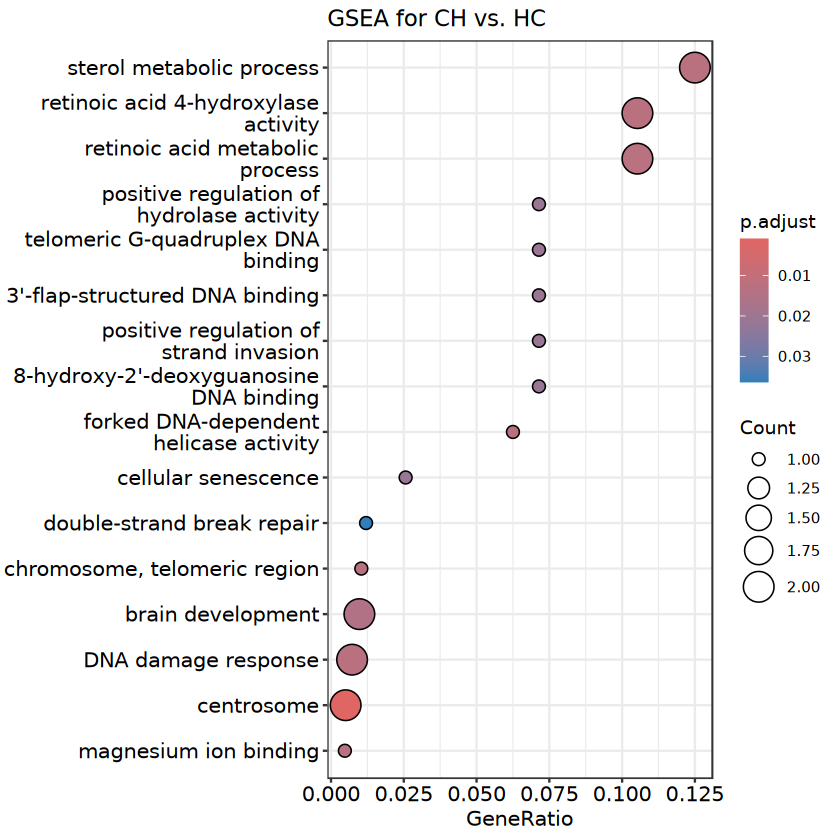

In [54]:
dotplot(gsea_res_ch.hc, showCategory=20) + ggtitle('GSEA for CH vs. HC')

In [53]:
# CB vs. BC
gsea_res_cb.bc <- GSEA(
    geneList = all_df$cb_bc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_cb.bc)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.51% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

### 4. No stress vs. most stress
- CC vs. WW
- CC vs. HH
- CC vs. BB

In [14]:
# CC vs. WW
gsea_res_cc.ww <- GSEA(
    geneList = all_df$ww_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_cc.ww))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.76% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0045886,GO:0045886,negative regulation of synaptic assembly at neuromuscular junction,10,0.9999043,1.468267,3.417302e-07,0.001250049,0.001250049,4,"tags=10%, list=0%, signal=10%",LOC111109183
GO:0017124,GO:0017124,SH3 domain binding,69,0.9996290,1.346816,7.112169e-07,0.001300816,0.001300816,4,"tags=1%, list=0%, signal=1%",LOC111109183
GO:0016607,GO:0016607,nuclear speck,289,-0.9973177,-1.240573,1.965483e-06,0.002396578,0.002396578,15,"tags=1%, list=0%, signal=1%",LOC111100591/LOC111125439
GO:0035262,GO:0035262,gonad morphogenesis,10,0.9998581,1.468200,5.784304e-06,0.005289746,0.005289746,4,"tags=10%, list=0%, signal=10%",LOC111109183
GO:0005777,GO:0005777,peroxisome,140,-0.9988176,-1.229984,9.747048e-06,0.007130940,0.007130940,5,"tags=1%, list=0%, signal=1%",LOC111124608/LOC111129387
GO:0003382,GO:0003382,epithelial cell morphogenesis,14,0.9997920,1.493578,2.168730e-05,0.013222021,0.013222021,4,"tags=7%, list=0%, signal=7%",LOC111109183


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the enrichplot package.
  Please report the issue at
  <https://github.com/GuangchuangYu/enrichplot/issues>.”


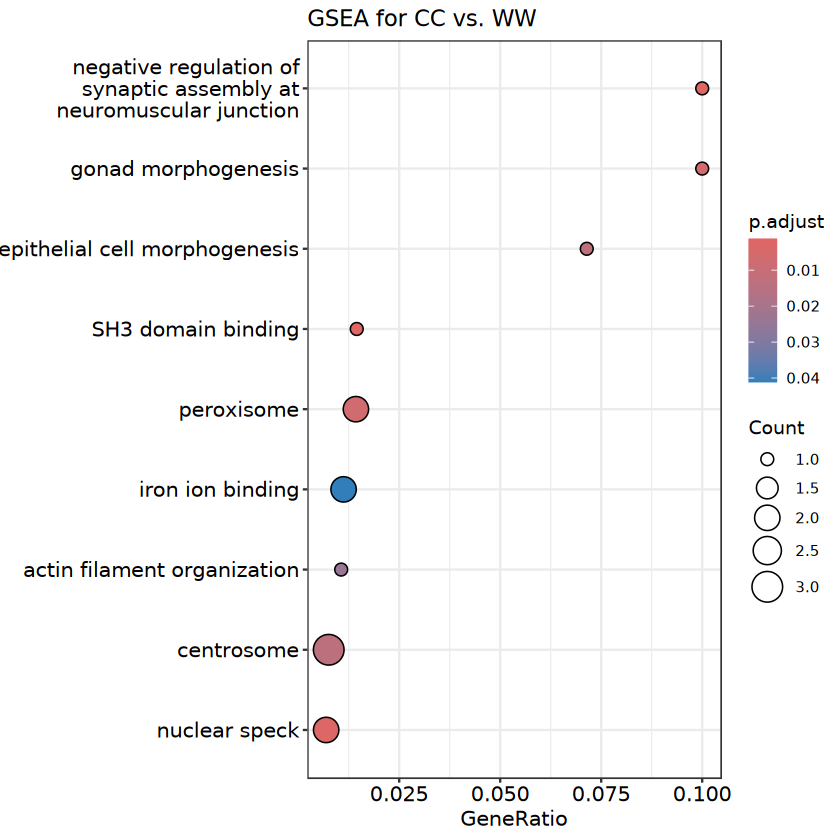

In [15]:
dotplot(gsea_res_cc.ww, showCategory=20) + ggtitle('GSEA for CC vs. WW')

In [16]:
# CC vs. HH
gsea_res_cc.hh <- GSEA(
    geneList = all_df$hh_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_cc.hh))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.71% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [17]:
# CC vs. BB
gsea_res_cc.bb <- GSEA(
    geneList = all_df$bb_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_cc.bb))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.53% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

### 5. Effect of initial exposure on response in later exposure

#### A. matched priming
- WW vs. CW
- HH vs. CH
- BB vs. CB

In [13]:
# WW vs. CW
gsea_res_ww.cw <- GSEA(
    geneList = all_df$ww_cw,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_ww.cw))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.81% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0005777,GO:0005777,peroxisome,140,-0.9993219,-1.243228,1.205359e-08,4.409204e-05,4.409204e-05,7,"tags=1%, list=0%, signal=1%",LOC111107393/LOC111129387
GO:0005813,GO:0005813,centrosome,397,-0.9962318,-1.288933,3.058885e-06,3.729801e-03,3.729801e-03,53,"tags=1%, list=0%, signal=1%",LOC111138453/LOC111102130/LOC111125439
GO:0016607,GO:0016607,nuclear speck,289,-0.9972904,-1.242474,2.280599e-06,3.729801e-03,3.729801e-03,10,"tags=1%, list=0%, signal=1%",LOC111138453/LOC111125439
GO:0007420,GO:0007420,brain development,205,-0.9972739,-1.238251,3.825981e-05,3.498860e-02,3.498860e-02,10,"tags=1%, list=0%, signal=1%",LOC111138453/LOC111125439


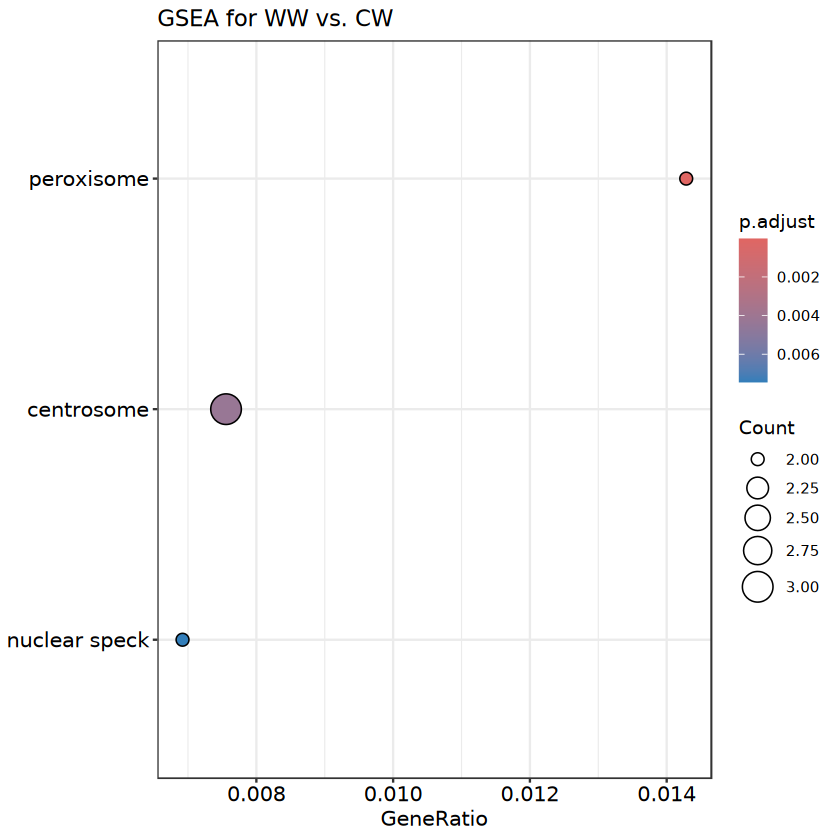

In [25]:
dotplot(gsea_res_ww.cw, showCategory=20) + ggtitle('GSEA for WW vs. CW')

In [20]:
# HH vs. CH
gsea_res_hh.ch <- GSEA(
    geneList = all_df$hh_ch,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_hh.ch))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.55% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0045886,GO:0045886,negative regulation of synaptic assembly at neuromuscular junction,10,-0.9997663,-1.494732,6.190246e-07,0.002264392,0.002264392,7,"tags=20%, list=0%, signal=20%",LOC111124521/LOC111109183
GO:0003743,GO:0003743,translation initiation factor activity,54,0.9880863,1.302200,1.368682e-05,0.025033187,0.025033187,114,"tags=2%, list=0%, signal=2%",LOC111134227
GO:0010591,GO:0010591,regulation of lamellipodium assembly,13,-0.9990357,-1.500692,3.595056e-05,0.043835713,0.043835713,7,"tags=15%, list=0%, signal=15%",LOC111128590/LOC111109183
GO:0046847,GO:0046847,filopodium assembly,28,-0.9951715,-1.526114,6.640984e-05,0.048694073,0.048694073,84,"tags=11%, list=0%, signal=11%",LOC111115612/LOC111110764/LOC111109183
GO:0043130,GO:0043130,ubiquitin binding,84,0.9659719,1.278844,6.655833e-05,0.048694073,0.048694073,99,"tags=1%, list=0%, signal=1%",LOC111121080


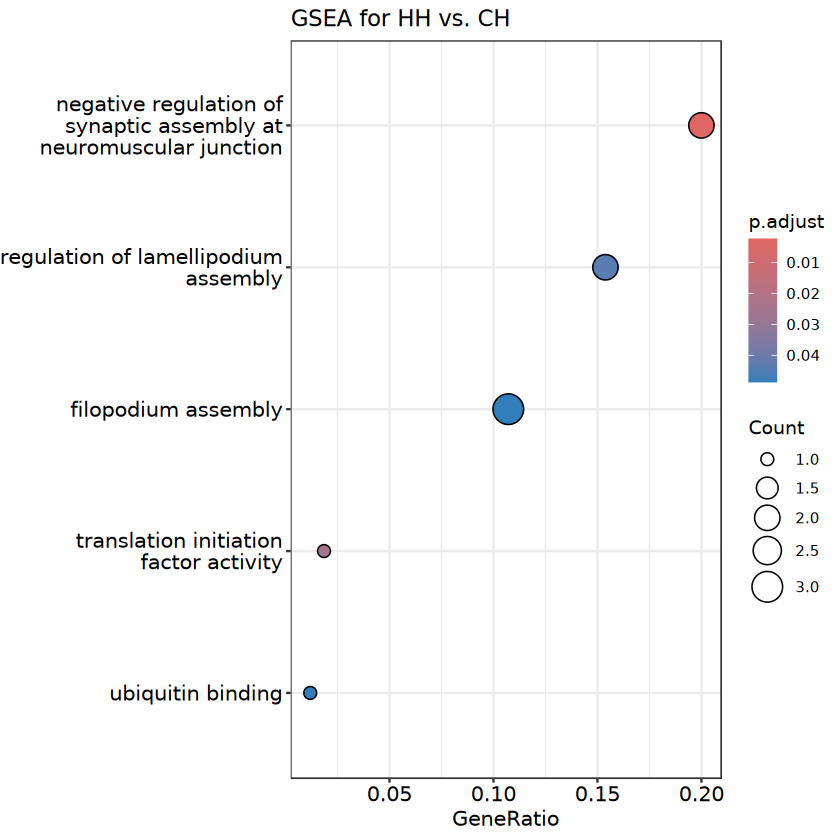

In [24]:
dotplot(gsea_res_hh.ch, showCategory=20) + ggtitle('GSEA for HH vs. CH')

In [33]:
# BB vs. CB
gsea_res_cb.bb <- GSEA(
    geneList = all_df$bb_cb,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_cb.bb))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.5% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0048813,GO:0048813,dendrite morphogenesis,90,-0.9978204,-1.219494,5.640102e-06,0.02063149,0.02063149,18,"tags=2%, list=0%, signal=2%",LOC111113548/LOC111109183
GO:0032956,GO:0032956,regulation of actin cytoskeleton organization,56,-0.9987403,-1.265737,2.105521e-05,0.02567331,0.02567331,18,"tags=4%, list=0%, signal=4%",LOC111113608/LOC111109183
GO:0016607,GO:0016607,nuclear speck,289,-0.9915963,-1.208165,1.665256e-05,0.02567331,0.02567331,63,"tags=1%, list=0%, signal=1%",LOC111138453/LOC111125439


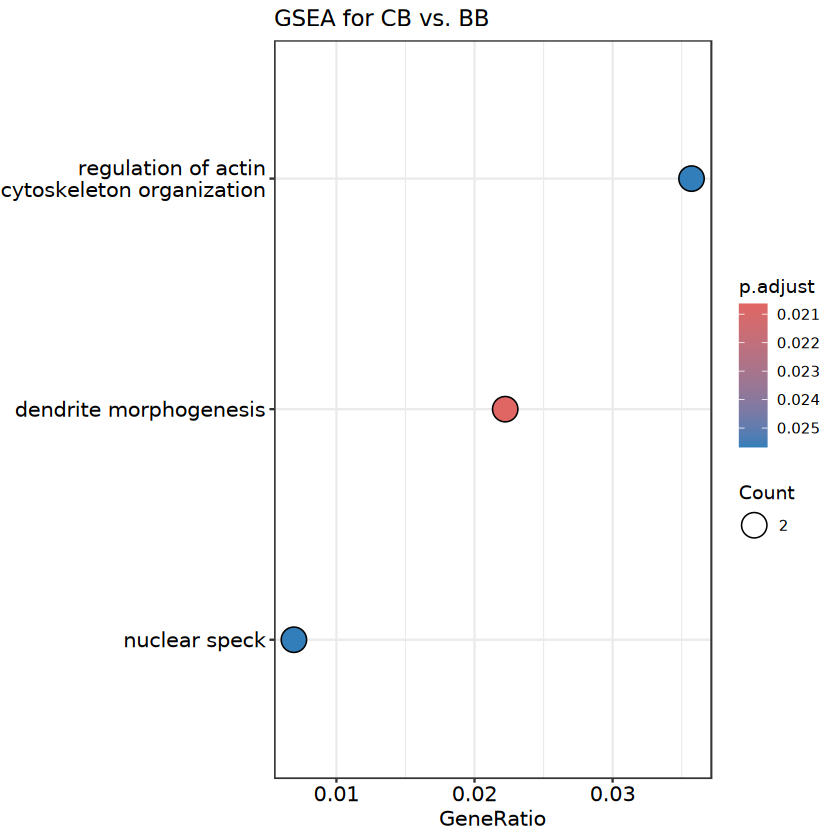

In [34]:
dotplot(gsea_res_cb.bb, showCategory=20) + ggtitle('GSEA for CB vs. BB')

#### B. semi-matched priming: in context of later single stress
- CH vs. BH
- CW vs. BW

In [15]:
# CH vs. BH
gsea_res_ch.bh <- GSEA(
    geneList = all_df$bh_ch,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_ch.bh))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.39% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [16]:
# CW vs. BW
gsea_res_cw.bw <- GSEA(
    geneList = all_df$bw_cw,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_cw.bw))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.84% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0007030,GO:0007030,Golgi organization,89,-0.9987204,-1.229321,9.834008e-07,0.00359728,0.00359728,5,"tags=2%, list=0%, signal=2%",LOC111122622/LOC111132581


#### C. semi-matched priming: in context of later multiple stress
- CB vs. WB
- CB vs. HB

In [46]:
# WB vs. CB
gsea_res_wb.cb <- GSEA(
    geneList = all_df$wb_cb,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_wb.cb))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.83% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
GO:0045886,GO:0045886,negative regulation of synaptic assembly at neuromuscular junction,10,0.9997767,1.373003,3.130574e-08,0.0001145164,0.0001145164,7,"tags=10%, list=0%, signal=10%",LOC111109183
GO:0032956,GO:0032956,regulation of actin cytoskeleton organization,56,0.9983522,1.276072,5.401533e-06,0.0071021132,0.0071021132,7,"tags=2%, list=0%, signal=2%",LOC111109183
GO:0017124,GO:0017124,SH3 domain binding,69,0.9975065,1.252945,6.435873e-06,0.0071021132,0.0071021132,7,"tags=1%, list=0%, signal=1%",LOC111109183
GO:0048813,GO:0048813,dendrite morphogenesis,90,0.9965358,1.242670,7.766116e-06,0.0071021132,0.0071021132,7,"tags=1%, list=0%, signal=1%",LOC111109183
GO:0005813,GO:0005813,centrosome,397,0.9779621,1.243001,5.478756e-05,0.0400825796,0.0400825796,23,"tags=0%, list=0%, signal=0%",LOC111125439


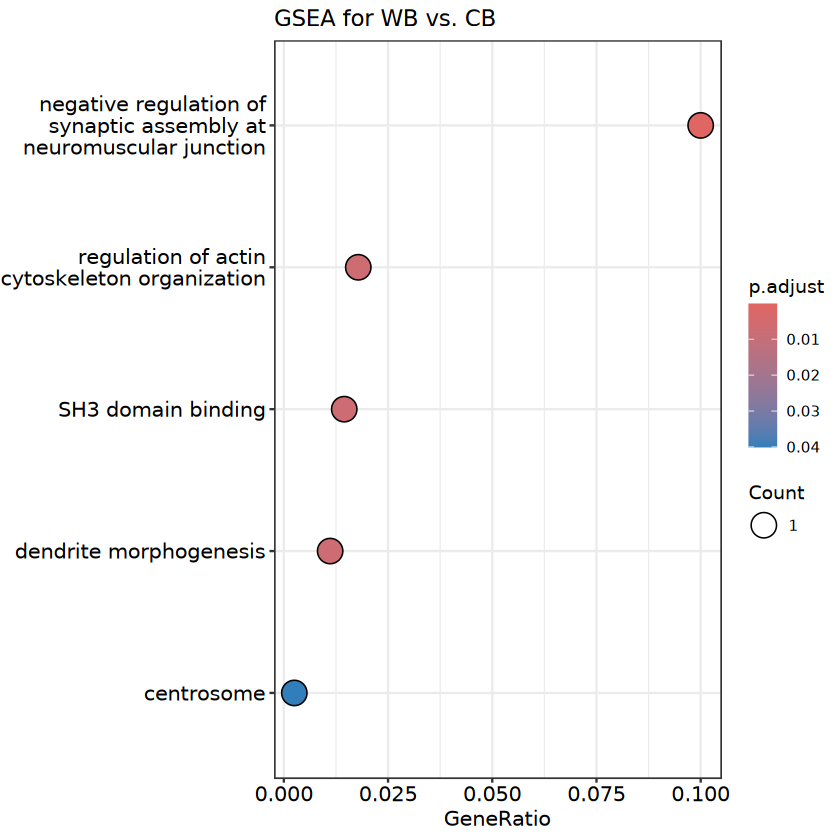

In [49]:
dotplot(gsea_res_wb.cb, showCategory=20) + ggtitle('GSEA for WB vs. CB')

In [50]:
# HB vs. CB
gsea_res_hb.cb <- GSEA(
    geneList = all_df$hb_cb,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_hb.cb))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.78% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0045886,GO:0045886,negative regulation of synaptic assembly at neuromuscular junction,10,0.9996435,1.365308,9.224823e-08,0.000136095,0.000136095,13,"tags=10%, list=0%, signal=10%",LOC111109183
GO:0035262,GO:0035262,gonad morphogenesis,10,0.9996134,1.365267,1.116143e-07,0.000136095,0.000136095,13,"tags=10%, list=0%, signal=10%",LOC111109183
GO:0016607,GO:0016607,nuclear speck,289,0.9976424,1.212750,4.358586e-08,0.000136095,0.000136095,16,"tags=0%, list=0%, signal=0%",LOC111125439
GO:0031267,GO:0031267,small GTPase binding,238,-0.9968070,-1.333538,1.206797e-06,0.001103616,0.001103616,56,"tags=1%, list=0%, signal=1%",LOC111102130/LOC111115778/LOC111101003
GO:0007369,GO:0007369,gastrulation,26,-0.9996501,-1.459972,3.235116e-06,0.001972342,0.001972342,5,"tags=8%, list=0%, signal=8%",LOC111132550/LOC111132581
GO:0007099,GO:0007099,centriole replication,28,-0.9996356,-1.455606,2.926352e-06,0.001972342,0.001972342,5,"tags=7%, list=0%, signal=7%",LOC111102807/LOC111132581


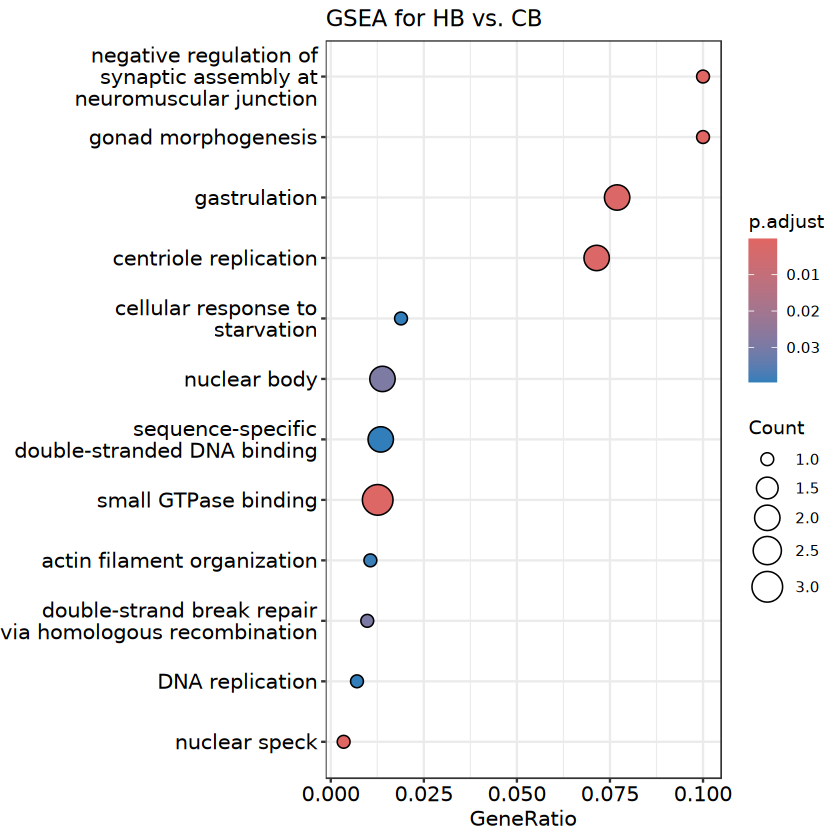

In [51]:
dotplot(gsea_res_hb.cb, showCategory=20) + ggtitle('GSEA for HB vs. CB')

### 6. Effect of initial exposure on subsequent response to stress
- WW vs. WC
- HH vs. HC
- BB vs. BC

In [19]:
# WW vs. WC
gsea_res_ww.wc <- GSEA(
    geneList = all_df$wc_ww,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_ww.wc))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.6% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [20]:
# HH vs. HC
gsea_res_hh.hc <- GSEA(
    geneList = all_df$hc_hh,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_hh.hc))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.5% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0000723,GO:0000723,telomere maintenance,85,-0.9764237,-1.247326,1.097159e-05,0.04013409,0.04013409,32,"tags=4%, list=0%, signal=4%",LOC111116305/LOC111116429/LOC111125439


In [22]:
# BB vs. BC
gsea_res_bb.bc <- GSEA(
    geneList = all_df$bc_bb,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_bb.bc))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.51% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

### 7. Effect of initial single/multiple stress on response in ...

#### 7A. ...later *single* stress
- BH vs. HH
- BW vs. WW

In [23]:
# BH vs. HH
gsea_res_bh.hh <- GSEA(
    geneList = all_df$bh_hh,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_bh.hh))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.5% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 4 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [24]:
# BW vs. WW
gsea_res_bw.ww <- GSEA(
    geneList = all_df$bw_ww,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_bw.ww))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.75% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

#### 7B. ...later *multiple* stressors
- HB vs. BB
- WB vs. BB

In [25]:
# HB vs. BB
gsea_res_hb.bb <- GSEA(
    geneList = all_df$hb_bb,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_hb.bb))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.51% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0016567,GO:0016567,protein ubiquitination,339,-0.9924598,-1.258474,2.131761e-06,0.007797983,0.007797983,154,"tags=1%, list=0%, signal=1%",LOC111107718/LOC111109691/LOC111110547/LOC111108308/LOC111107614
GO:0016604,GO:0016604,nuclear body,144,-0.9960874,-1.239225,3.123901e-05,0.041068581,0.041068581,34,"tags=1%, list=0%, signal=1%",LOC111126963/LOC111099037
GO:0043204,GO:0043204,perikaryon,178,-0.9954729,-1.222502,3.368118e-05,0.041068581,0.041068581,70,"tags=2%, list=0%, signal=2%",LOC111116878/LOC111101003/LOC111115778/LOC111132233


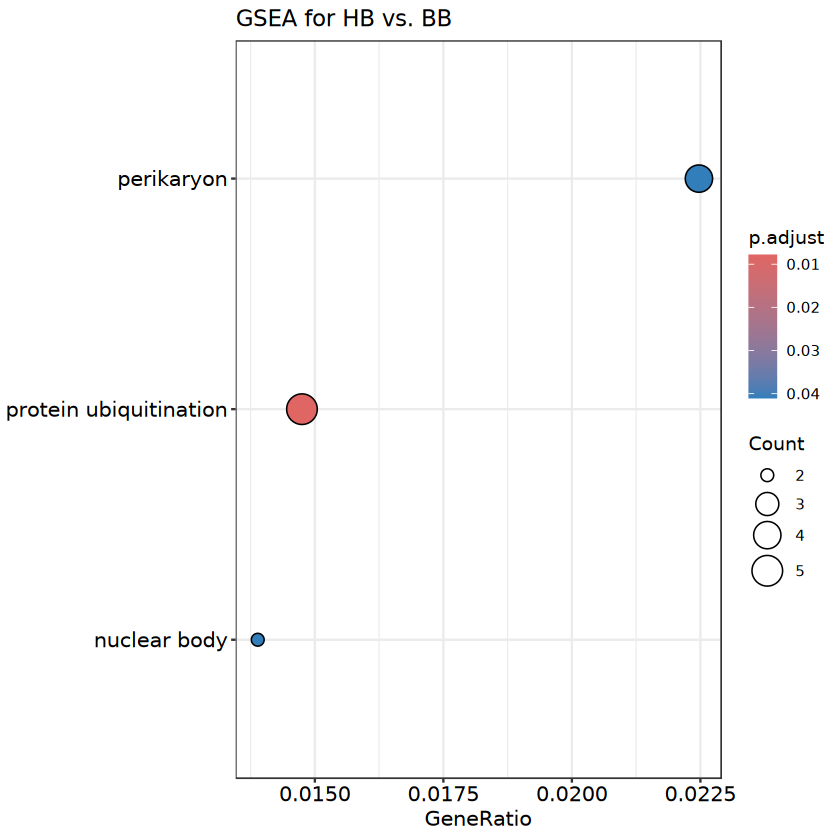

In [26]:
dotplot(gsea_res_hb.bb, showCategory=20) + ggtitle('GSEA for HB vs. BB')

In [27]:
# WB vs. BB
gsea_res_wb.bb <- GSEA(
    geneList = all_df$wb_bb,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_wb.bb))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.54% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

### 8. Shared/unique response among stressors with ...

#### 8A. ...different *early* stressors
- WC vs. HC
- BC vs. HC
- BC vs. WC

In [28]:
# WC vs. HC
gsea_res_wc.hc <- GSEA(
    geneList = all_df$wc_hc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_wc.hc))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.41% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [29]:
# BC vs. HC
gsea_res_bc.hc <- GSEA(
    geneList = all_df$bc_hc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_bc.hc))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.38% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0006284,GO:0006284,base-excision repair,46,0.9951862,1.206814,4.127199e-06,0.01007072,0.01007072,24,"tags=2%, list=0%, signal=2%",LOC111125439
GO:0090398,GO:0090398,cellular senescence,39,0.9962565,1.204515,5.506134e-06,0.01007072,0.01007072,24,"tags=3%, list=0%, signal=3%",LOC111125439
GO:0019903,GO:0019903,protein phosphatase binding,228,-0.9082983,-1.729765,5.773988e-05,0.03480426,0.03480426,359,"tags=4%, list=1%, signal=4%",LOC111104356/LOC111111770/LOC111107461/LOC111112756/LOC111110123/LOC111109376/LOC111113056/LOC111108540/LOC111106424/LOC111113858
GO:0006888,GO:0006888,endoplasmic reticulum to Golgi vesicle-mediated transport,187,-0.9286720,-1.702721,7.123336e-05,0.03480426,0.03480426,368,"tags=5%, list=1%, signal=5%",LOC111104356/LOC111126887/LOC111111770/LOC111107461/LOC111110123/LOC111109376/LOC111113056/LOC111108540/LOC111106424/LOC111113858
GO:0002039,GO:0002039,p53 binding,36,-0.9945054,-1.564264,8.563104e-05,0.03480426,0.03480426,46,"tags=6%, list=0%, signal=6%",LOC111108129/LOC111105271
GO:1902570,GO:1902570,protein localization to nucleolus,23,0.9971300,1.231232,8.390916e-05,0.03480426,0.03480426,24,"tags=4%, list=0%, signal=4%",LOC111125439


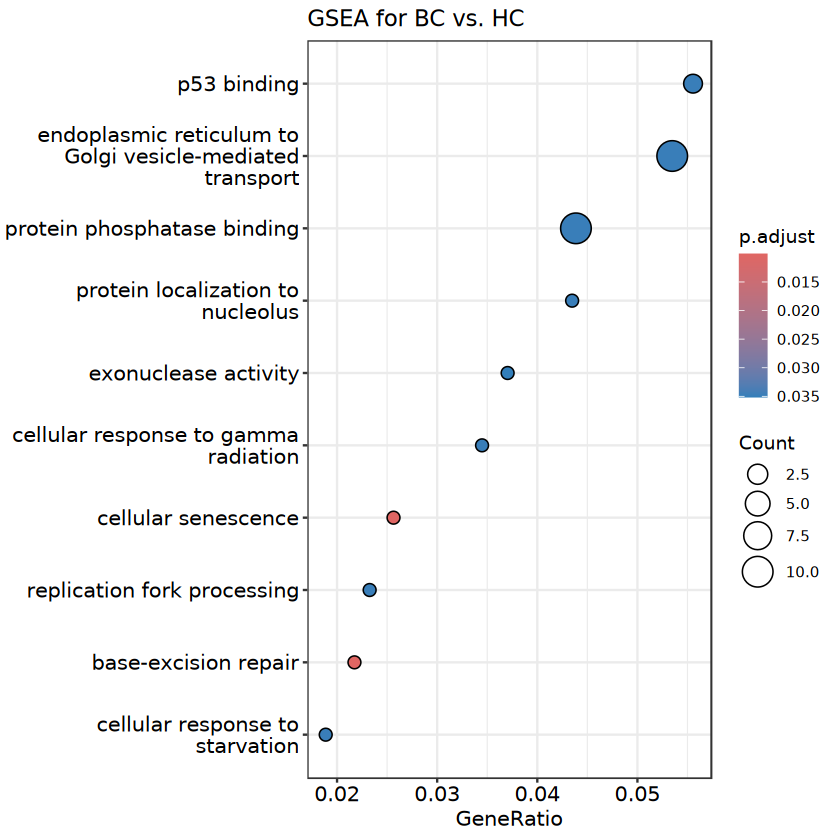

In [30]:
dotplot(gsea_res_bc.hc, showCategory=20) + ggtitle('GSEA for BC vs. HC')

In [31]:
# BC vs. WC
gsea_res_bc.wc <- GSEA(
    geneList = all_df$bc_wc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_bc.wc))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.38% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enirched GO terms

#### 8B. ...different *late* stressors
- CW vs. CH
- CB vs. CH
- CB vs. CW

In [32]:
# CW vs. CH
gsea_res_cw.ch <- GSEA(
    geneList = all_df$cw_ch,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_cw.ch))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.64% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [33]:
# CB vs. CH
gsea_res_cb.ch <- GSEA(
    geneList = all_df$cb_ch,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_cb.ch))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.63% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [34]:
# CB vs. CW
gsea_res_cb.cw <- GSEA(
    geneList = all_df$cb_cw,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_cb.cw))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.81% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

### 9. Effect of order of stressors on GE
- WH vs. HW
- WB vs. BW
- HB vs. BH

In [37]:
# WH vs. HW
gsea_res_wh.hw <- GSEA(
    geneList = all_df$wh_hw,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_wh.hw))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.51% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [38]:
# WB vs. BW
gsea_res_wb.bw <- GSEA(
    geneList = all_df$wb_bw,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_wb.bw))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.79% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [39]:
# HB vs. BH
gsea_res_hb.bh <- GSEA(
    geneList = all_df$hb_bh,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_hb.bh))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.55% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms